In [17]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex

# Utils
from utils.data_utils import load_cmsopendata
from utils.plot_utils import plot_event
from ot.lp import emd2

# Jets
from pyjet import cluster



# GPU nonsense
import torch 
import torch.nn as nn

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


Using CPU!


# Data

Max # of particles: 100
Max # of particles: 129
test
(250,)


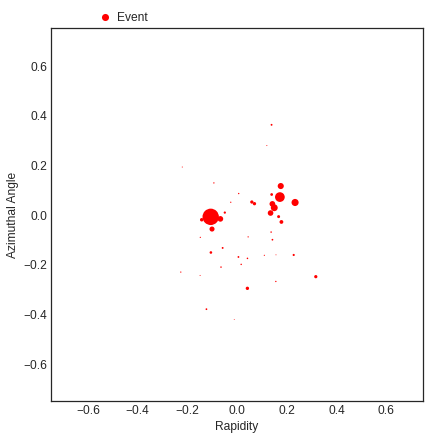

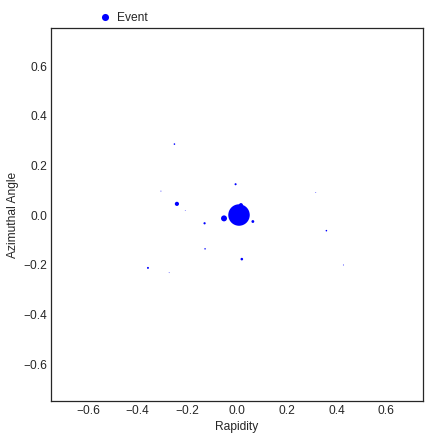

<AxesSubplot:xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [18]:
# Parameters
R = 0.5
beta = 1.0
N = 250
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N)
sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)
print(cms_weights.shape)
events = (cms, sim)



# signal, signal_masses = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta_cut)
# background, background_masses = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta_cut)
# events = [signal, background]
# event_labels = ["signal", "background"]
# colors = ["red", "blue"]


fake_top, fake_top_z = np.array(( (-1.0,0.0), (0.0,0.0), (1.0,0.0),)), np.array((1/3, 1/3, 1/3))
fake_signal = ((fake_top, fake_top_z), )
fake_quark, fake_quark_z = np.array(((0.0,0.0),)), np.array((1.0, ))
fake_background = ((fake_quark, fake_quark_z),)
fake_events = [fake_signal, fake_background]


# Example plots
example_cms = cms[0]
plot_event(example_cms[0], example_cms[1], R, color = "red")

example_sim = sim[0]
plot_event(example_sim[0], example_sim[1], R, color = "blue")


In [19]:


emds_old = np.zeros(shape = (len(events), N))
times_old = np.zeros(shape = (len(events), N))




In [20]:


from random import sample


ns = [1, 2, 4, 8, 16, 32]
epsilons = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.99]

emds_pot = np.zeros((len(ns), N))
emds_sinkhorn = np.zeros((len(epsilons), len(ns), N))
times_sinkhorn = np.zeros((len(epsilons), len(ns)))

# ###############
# ##### POT #####
# ###############

for (i, n) in enumerate(ns):

    points, zs = [], []
    for y in np.linspace(-R,R, n):
            for phi in np.linspace(-R, R, n):

                points.append((y, phi))
                zs.append(1.0 / (n**2))


    refernce_event = (np.array(points), np.array(zs))

    def _cdist_phi_y(X,Y, ym):
        # define ym as the maximum rapidity cut on the quasi-isotropic event
        # Make sure the phi values are in range                                                                                                                                          
        phi1 = (X[:,1])
        phi2 = (Y[:,1])
        # Trick to account for phi distance periodicity
        phi_d = ((phi1[:,np.newaxis] - phi2[:])) 
        # norm = 12.0/(np.pi*np.pi+16*ym*ym)
        norm = 1
        y_d = X[:,0,np.newaxis] - Y[:,0]
        dist =(phi_d**2 + y_d**2)
        return dist

    # Calculate the EMDs for each observable, for each event
    for (k, event) in enumerate(cms):

        t1 = time()
        xi, ai = event
        yj, bj = refernce_event
        M = _cdist_phi_y(xi, yj, R)
        emd_val, log = emd2(ai.astype(np.float64) / ai.sum().astype(np.float64), bj.astype(np.float64)/ bj.sum().astype(np.float64), M,log=True)
        # Should only return 0 when two events are identical. If returning 0 otherwise, problems in config
        if emd_val==0:
            print(log['warning'])
        emds_pot[i,k] = emd_val
        t2 = time()


    print(np.mean(emds_pot[i]))





# ####################
# ##### SINKHORN #####
# ####################

observables = {}


def build_reference_event(n):
    points, zs = [], []
    for y in np.linspace(-R,R, n):
            for phi in np.linspace(-R, R, n):

                points.append((y, phi))
                zs.append(1.0 / (n**2))

    refernce_event = (np.array(points), np.array(zs))
    return refernce_event


def isotropy_samples(n, param_dict, refernce_event, dtype=torch.FloatTensor):

        zs = torch.from_numpy(refernce_event[1]).type(dtype)
        points = torch.from_numpy(refernce_event[0]).type(dtype)
        return (points, zs)

ref1 = build_reference_event(1)
ref2 = build_reference_event(2)
ref4 = build_reference_event(4)
ref8 = build_reference_event(8)
ref16 = build_reference_event(16)
ref32 = build_reference_event(32)

samples1 = lambda n, param_dict: isotropy_samples(n, param_dict, ref1)
samples2 = lambda n, param_dict: isotropy_samples(n, param_dict, ref2)
samples4 = lambda n, param_dict: isotropy_samples(n, param_dict, ref4)
samples8 = lambda n, param_dict: isotropy_samples(n, param_dict, ref8)
samples16 = lambda n, param_dict: isotropy_samples(n, param_dict, ref16)
samples32 = lambda n, param_dict: isotropy_samples(n, param_dict, ref32)

_isotropy1 = Observable({}, samples1, beta = 2, R = R)
_isotropy2 = Observable({}, samples2, beta = 2, R = R)
_isotropy4 = Observable({}, samples4, beta = 2, R = R)
_isotropy8 = Observable({}, samples8, beta = 2, R = R)
_isotropy16 = Observable({}, samples16, beta = 2, R = R)
_isotropy32 = Observable({}, samples32, beta = 2, R = R)


observables["Isotropy_1"] = _isotropy1
observables["Isotropy_2"] = _isotropy2
observables["Isotropy_4"] = _isotropy4
observables["Isotropy_8"] = _isotropy8
observables["Isotropy_16"] = _isotropy16
observables["Isotropy_32"] = _isotropy32



shaper = Shaper(observables, device)
shaper.to(device)

emds = []
times = []
for (e,epsilon) in enumerate(epsilons):


    print(epsilon)

    shapers = []

    for (i, n) in enumerate(ns):

        t1 = time()

        shaper = Shaper({"Isotropy_%d" % n : observables["Isotropy_%d" % n]}, device)
        shaper.to(device)
        shapers.append(shaper)
        signal_emds, signal_params = shaper.calculate(cms, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = epsilon, early_stopping= 25, N = 500)


        emds_sinkhorn[e,i] = signal_emds["Isotropy_%d" % n]
        times_sinkhorn[e,i] = time() - t1



In [21]:
np.save("emds_sinkhorn", emds_sinkhorn)
np.save("times_sinkhorn", times_sinkhorn)

np.save("emds_pot", emds_pot)

emds_sinkhorn = np.load("emds_sinkhorn.npy")
times_sinkhorn = np.load("times_sinkhorn.npy")
emds_pot = np.load("emds_pot.npy")

accuracies = 2 * emds_sinkhorn / emds_pot[None,:,:]



[1.2979214191436768, 1.42966890335083, 1.5271072387695312, 2.600879669189453, 10.492105484008789, 98.61651706695557]
[1.0244817733764648, 1.0580835342407227, 1.1372363567352295, 1.8214242458343506, 8.31103777885437, 59.51677179336548]
[0.6713497638702393, 0.7452304363250732, 0.7724506855010986, 1.237900733947754, 4.515225172042847, 35.41183614730835]
[0.4323873519897461, 0.4682912826538086, 0.485400915145874, 0.7516000270843506, 2.9022891521453857, 21.373530387878418]
[0.18345999717712402, 0.2285478115081787, 0.22535419464111328, 0.36371850967407227, 1.0720407962799072, 10.198362350463867]


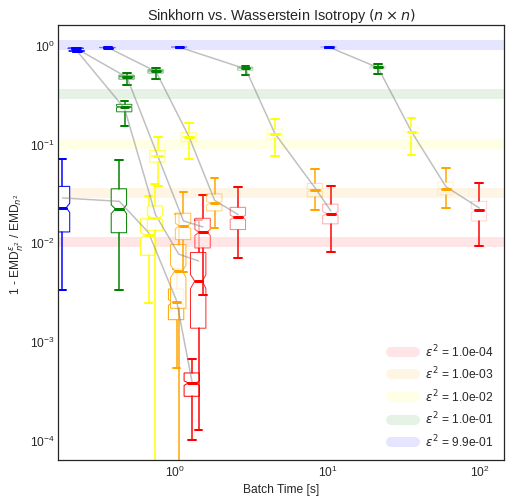

In [26]:




fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '12'
lims = [0, 1.0]
colors = ["red", "orange", "yellow", "green", "blue", "purple"]

w = 0.1
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)


for (e, eps) in enumerate(epsilons):

    print(times_sinkhorn[e].tolist())
    bp = ax.boxplot((1-accuracies[e]).tolist(), positions = times_sinkhorn[e], showfliers=False, patch_artist = True, notch=True, widths=width(times_sinkhorn[e],w))

    for i,patch in enumerate(bp['boxes']):
        patch.set(color = "white", alpha = (len(ns) - i) / len(ns), edgecolor= colors[e])

    for whisker in bp['whiskers']:
        whisker.set(color =colors[e],
                    linewidth = 1.5,
                    # linestyle =":"
                    )
    
    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color = colors[e],
                linewidth = 2)
    
    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color =colors[e],
                linewidth = 3)


    average = np.mean(1-accuracies[e], axis = 1)
    # plt.plot(times_sinkhorn[e], average, color = "gray")
    plt.axhline(np.sqrt(epsilons[e]), color = colors[e], label = "$\epsilon^2$ = %.1e" % eps, linewidth = 10, alpha = 0.10)


for (i, n) in enumerate(ns):
    average = np.mean(1-accuracies[:,i,:], axis = 1)
    plt.plot(times_sinkhorn[:,i], average, color = "gray", alpha = 0.5)


    # plt.boxplot(accuracies[e].tolist(), positions=times_sinkhorn[e].tolist())

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Batch Time [s]")
plt.ylabel("1 - EMD$^\epsilon_{n^2}$ / EMD$_{n^2}$")
plt.title(r"Sinkhorn vs. Wasserstein Isotropy $(n\times n)$")
plt.legend()
# plt.ylabel(r"$\mathcal{I}_{%d}^{\epislon} / \mathcal{I}_{%d}$" % (n**2, n**2) )
plt.show()


# for (i,n) in enumerate(ns):
#     for (e, eps) in enumerate(epsilons):
#         # plt.hist(emds_old[0,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "red", label = "Signal Old", histtype="stepfilled", alpha = 0.5)
#         plt.hist( 1- accuracies[e,i] , range = lims, bins = 25, density = True, color = "red", label = "Signal $\epsilon$ = %.1e" % eps, histtype="step", alpha = (len(epsilons) - e) / len(epsilons), lw = 3)
#     # plt.hist(emds_pot[i] / 2, range = lims, bins = 25, density = True, color = "Black", label = "Signal POT", histtype="step", lw = 3)
#     plt.title(r"Event Isotropy ($%d\times%d$)" %(n,n) )
#     plt.xlabel(r"$\mathcal{I}_{%d}^{\epislon} / \mathcal{I}_{%d}$" % (n**2, n**2) )
#     plt.ylabel(r"Density" )
#     plt.legend()
#     # plt.savefig("Plots/signal_annealing.pdf")
#     plt.show()
    
# plt.figure(figsize=(6, 6))
# plt.rcParams['font.size'] = '12'

# for j in range(1):
#     for (e, eps) in enumerate(epsilons):

#         # plt.hist(emds_old[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
#         plt.hist(emds_sinkhorn[1,j,e,:] , bins = 25, range=(0.05, 0.25), density = True, color = "blue", label = "Background Scale = %.1f" % eps, histtype="step", alpha = (1 + e) / len(epsilons), lw = 3)
#     plt.hist(emds_old[1,:] / 2, bins = 25, range=(0.05, 0.25), density = True, color = "Black", label = "Background POT", histtype="step", lw = 3)
#     plt.title(r"Event Isotropy ($25\times25$)")
#     plt.xlabel(r"Isotropy")
#     plt.ylabel(r"Density" )
#     plt.legend( )
#     plt.savefig("Plots/backgrounds_annealing.pdf")
#     plt.show()

# for j in range(3):
#     plt.hist(emds_old[1,j,:] * 0.5 / 0.8 , bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
#     plt.hist(emds_sinkhorn[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "darkblue", label = "Background Sinkhorn", histtype="stepfilled", alpha = 0.5)
#     plt.title(r"$\tau_{%d}$" % (j+1))
#     plt.xlabel(r"$\tau_{%d}$" % (j+1))
#     plt.legend()
#     plt.show()


In [23]:
# plt.hist(signal_emds["2 Subjettiness"] / signal_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
# plt.hist(background_emds["2 Subjettiness"] / background_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
# plt.legend()
# plt.show()

# plt.hist(signal_emds["3 Subjettiness"] / signal_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
# plt.hist(background_emds["3 Subjettiness"] / background_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
# plt.legend()

# Benchmarks - Apollonius

In [24]:
# Interpolate between max subjettiness, ---rhos--- isotropy
rhos = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
observables = {"MAX Subjettiness": _MAXsubjettiness}
for rho in rhos:
    _apollonius = (_MAXsubjettiness + _isotropy)
    _apollonius.freeze("Joint Weights", np.array([1 - rho, rho]))
    observables["Apollonius %d" % (rho * 10)] = _apollonius
observables["Isotropy"] = _isotropy

shaper = Shaper(observables)

# print(signal[0][1])
cms_emds, _ = shaper.calculate(cms, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
sim_emds, _ = shaper.calculate(sim, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)
_ = 0

NameError: name '_MAXsubjettiness' is not defined

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

# print(signal_emds, background_emds)

for (i, rho) in enumerate(rhos):
    sg_ys.append(np.mean(cms_emds["Apollonius %d" %i]))
    sg_errs.append(np.std(cms_emds["Apollonius %d" %i]))
    bg_ys.append(np.mean(sim_emds["Apollonius %d" %i]))
    bg_errs.append(np.std(sim_emds["Apollonius %d" %i]))

plt.errorbar(np.array(rhos) + 0.01, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(rhos, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
plt.axhline(np.mean(cms_emds["Isotropy"]), color = "red", linestyle = "--")
plt.axhline(np.mean(sim_emds["Isotropy"]), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "CMS Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "SIM Jets"),
                 Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),]
plt.legend(handles = custom_legend)
plt.xlabel(r"$\rho$")
plt.ylabel("EMD")
plt.title("Apollonius EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

In [ ]:
range = [.2, 1.0]
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

def plot_hist(obs, color, label):

    bins = 25
    counts,bin_edges = np.histogram(cms_emds[obs] / np.max(cms_emds[obs]),bins = bins, range = range, weights= cms_weights)
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_emds[obs] / np.max(cms_emds[obs]), bins=bins, weights=cms_weights*cms_weights)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    plt.errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    plt.hist(sim_emds[obs] / np.max(sim_emds[obs] ), bins = 25, weights = sim_weights * sim_factors, range = range, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)



plot_hist("Apollonius 2", "red", r"$\rho = 0.2$")
plot_hist("Isotropy", "blue", "Isotropy")
# plot_hist("Apollonius 6", "yellow")
# plot_hist("Apollonius 8", "green")
# plot_hist("Apollonius 10", "blue")


xlabel = r'Apollonius EMD / Max'
ylabel = 'Differential Cross Section [nb]'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Apollonius Distributions')
plt.legend()


In [ ]:
# How far is each event from its (normalized) corrected event?

for rho in rhos:
    observables["Apollonius %d" % (rho * 10)].freeze("Weights")
    observables["Apollonius %d" % (rho * 10)].freeze("Joint Weights")

# Benchmarks - Nsubjettiness

In [ ]:
# Interpolate between max subjettiness, ---rhos--- isotropy
N = np.arange(1,126)
observables = {}
for n in N:

    _nsubjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
    observables["%d-Subjettiness" % n] = _nsubjettiness

shaper = Shaper(observables)

# print(signal[0][1])
cms_njettiness, _ = shaper.calculate(cms, epochs = 25, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
sim_njettiness, _ = shaper.calculate(sim, epochs = 25, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'



cms_njettiness["0-Subjettiness"] = np.zeros_like(cms_njettiness["1-Subjettiness"])
sim_njettiness["0-Subjettiness"] = np.zeros_like(sim_njettiness["1-Subjettiness"])

# print(signal_emds, background_emds)

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

for n in N:
    sg_ys.append(np.mean(np.nan_to_num(cms_njettiness["%d-Subjettiness" % n] / cms_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
    sg_errs.append(np.std(cms_njettiness["%d-Subjettiness" % n]/ cms_njettiness["%d-Subjettiness" % (n-1)])*0)
    bg_ys.append(np.mean(np.nan_to_num(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
    bg_errs.append(np.std(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)])*0)


print(len(sg_ys), N.shape)

plt.errorbar(N + 0.1, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(N, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# # plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
# plt.axhline(np.mean(signal_emds["Isotropy"] * 0.95), color = "red", linestyle = "--")
# plt.axhline(np.mean(background_emds["Isotropy"] * 0.94), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "Top Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "QCD Jets"),
                #  Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),
                 ]
plt.legend(handles = custom_legend)
plt.xlabel(r"$N$")
plt.ylabel("EMD")
# plt.yscale("log")
plt.ylim([0,1])
plt.title("N-Subjettiness EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

In [ ]:
range = [0, 1]
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = '12'

def plot_hist(obs, color, label):

    bins = 25
    counts,bin_edges = np.histogram(cms_njettiness[obs] / np.max(cms_njettiness[obs]),bins = bins, range = range, weights= cms_weights)
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_njettiness[obs] / np.max(cms_njettiness[obs]), bins=bins, weights=cms_weights*cms_weights)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    plt.errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    plt.hist(sim_njettiness[obs] / np.max(cms_njettiness[obs] ), bins = 25, weights = sim_weights * sim_factors, range = range, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)



# plot_hist("1-Subjettiness", "red", r"$N = 1$")
# plot_hist("2-Subjettiness", "orange", r"$N = 2$")
# plot_hist("3-Subjettiness", "yellow", r"$N = 3$")
# plot_hist("5-Subjettiness", "green", r"$N = 5$")
# plot_hist("10-Subjettiness", "blue", r"$N = 10$")
# plot_hist("25-Subjettiness", "purple", r"$N = 25$")
plot_hist("50-Subjettiness", "black", r"$N = 50$")

# plot_hist("Apollonius 6", "yellow")
# plot_hist("Apollonius 8", "green")
# plot_hist("Apollonius 10", "blue")


xlabel = r'N-Jettiness / Max'
ylabel = 'Differential Cross Section [nb]'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Apollonius Distributions')
plt.legend()

# Benchmarks - Isotopy
My code vs. Cari's

In [ ]:
ym = 0.8
norm = 12.0/(np.pi*np.pi+16*ym*ym)

# Reference Event
n = 15
points = []
zs = []
for y in np.linspace(-0.8, 0.8, n):
    for phi in np.linspace(-0.8, 0.8, n):

        points.append((y, phi))
        zs.append(1.0 / (n**2))
refernce_event = (np.array(points), np.array(zs))

In [ ]:
from ot.lp import emd2


emds_old = np.zeros(shape = (len(events), N))
times_old = np.zeros(shape = (len(events), N))

def _cdist_phi_y(X,Y, ym):
    # define ym as the maximum rapidity cut on the quasi-isotropic event
    # Make sure the phi values are in range                                                                                                                                          
    phi1 = (X[:,1])
    phi2 = (Y[:,1])
    # Trick to account for phi distance periodicity
    phi_d = ((phi1[:,np.newaxis] - phi2[:])) 
    norm = 12.0/(np.pi*np.pi+16*ym*ym)
    y_d = X[:,0,np.newaxis] - Y[:,0]
    dist = norm * (phi_d**2 + y_d**2)
    return dist

# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
        for (k, event) in enumerate(events[i]):

            t1 = time()
            xi, ai = event
            yj, bj = refernce_event
            M = _cdist_phi_y(xi, yj, 0.8)
            emd_val, log = emd2(ai.astype(np.float64) / ai.sum().astype(np.float64), bj.astype(np.float64)/ bj.sum().astype(np.float64), M,log=True)
            # Should only return 0 when two events are identical. If returning 0 otherwise, problems in config
            if emd_val==0:
                print(log['warning'])
            emds_old[i,k] = emd_val
            t2 = time()
            times_old[i,k] = t2 - t1

            print("Event %d" %k, "Class: %s" % event_labels[i], "Value: %.6f" % emd_val, "Finished in %.3fs" % (t2 - t1))

print(np.sum(times_old))

In [ ]:
labels = ["Isotropy"]
epsilons = [0.0001, 0.001, 0.01, 0.1, 0.99]

emds_sinkhorn = np.zeros(shape = (len(events), len(epsilons), N))
times_sinkhorn = np.zeros(shape = (len(events), len(epsilons)))

def uniform_grid(N, param_dict):

        n = int(np.sqrt(N))
        points = []
        zs = []
        for y in np.linspace(-0.8, 0.8, n):
                for phi in np.linspace(-0.8, 0.8, n):

                        points.append((y, phi))
                        zs.append(1.0 / (n**2))
        return (torch.Tensor(points), torch.Tensor(zs))


isotropy = Observable({}, uniform_grid, beta = 2, R = 1)
shaper = Shaper({"Isotropy": isotropy})


# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
        for (e, eps) in enumerate(epsilons):

                t1 = time()
                emd = shaper.calculate(events[i], epochs= 500, lr = 0.05, beta=2, N = 225, epsilon=eps, scaling = 0.75)
                emds_sinkhorn[i,e,:] = (emd["Isotropy"] * norm).detach().numpy()
                t2 = time()
                times_sinkhorn[i,e] = t2 - t1

                print("Obs: %s-%.1e" % (labels[0], eps), "Class: %s" % event_labels[i], "Finished in %.3fs" % (t2 - t1))

print(np.sum(times_sinkhorn))


In [ ]:
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

for (e, eps) in enumerate(epsilons):
    print(np.mean(emds_sinkhorn[0,e,:] / norm))
    # plt.hist(emds_old[0,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "red", label = "Signal Old", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds_sinkhorn[0,e,:] , bins = 25, range=(0.00, 0.1), density = True, color = "red", label = "Signal $\epsilon$ = %.1f" % eps, histtype="step", alpha = (len(epsilons)- e) / len(epsilons), lw = 3)
print(np.mean(emds_old[0,:] /2 / emds_sinkhorn[0,0,:]))
plt.hist(emds_old[0,:] /2, bins = 25, range=(0.00, 0.1), density = True, color = "Black", label = "Signal POT", histtype="step", lw = 3)
plt.title(r"Event Isotropy ($25\times25$)" )
plt.xlabel(r"Isotropy" )
plt.ylabel(r"Density" )
plt.legend()
# plt.savefig("Plots/signal_annealing.pdf")
plt.show()
    
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

for (e, eps) in enumerate(epsilons):

    # plt.hist(emds_old[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds_sinkhorn[1,e,:] , bins = 25, range=(0.00, 0.1), density = True, color = "blue", label = "Background $\epsilon$ = %.1f" % eps, histtype="step", alpha = (len(epsilons)- e) / len(epsilons), lw = 3)
plt.hist(emds_old[1,:] / 2, bins = 25, range=(0.00, 0.1), density = True, color = "Black", label = "Background POT", histtype="step", lw = 3)
plt.title(r"Event Isotropy ($25\times25$)")
plt.xlabel(r"Isotropy")
plt.ylabel(r"Density" )
plt.legend( )
# plt.savefig("Plots/backgrounds_annealing.pdf")
plt.show()

# for j in range(3):
#     plt.hist(emds_old[1,j,:] * 0.5 / 0.8 , bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
#     plt.hist(emds_sinkhorn[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "darkblue", label = "Background Sinkhorn", histtype="stepfilled", alpha = 0.5)
#     plt.title(r"$\tau_{%d}$" % (j+1))
#     plt.xlabel(r"$\tau_{%d}$" % (j+1))
#     plt.legend()
#     plt.show()